In [ ]:
!pip install scikit-maad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from librosa import feature
from maad import sound
from time import time
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


sns.set_theme()
plt.rcParams["figure.figsize"] = (17, 5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%% Set variables
path_annotations = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio_labels.csv'  # manual annotations in csv table
path_audio = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio/'  # directory where the audio data is located
path_results = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/results/'
target_fs = 10000  # set target sampling rate for audio

In [ ]:
#%% Load annotations
df = pd.read_csv(path_annotations)  

In [ ]:
df.shape

(1104, 7)

In [ ]:
df.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav


In [ ]:
df['label'].unique()

array(['SENSAT', 'MURCIE', 'INSECT', 'LLUVIA', 'PULSOS', 'HERPET',
       'ANTROP', 'AVEVOC', 'TRAMOT', 'INDETE', 'PASOS', 'FLUAGU',
       'ANIDOM'], dtype=object)

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

classifier = LogisticRegression(penalty='l1',class_weight='balanced',max_iter=2666,solver='saga')

# Pipeline, should we normalize/standarize?
pipe = Pipeline ([#("cleaner", predictors()),
                 #("standarize", ),
                 ("classifier", classifier)])

# Classifiers to use
clfs = [LinearSVC(class_weight='balanced',max_iter=2666, random_state=0, tol=1e-5),
        SGDClassifier(class_weight='balanced',max_iter=2666, tol=1e-3),
        SVC(kernel='rbf',degree=3,gamma='scale',class_weight='balanced'),
        LogisticRegression(penalty='l1',class_weight='balanced',max_iter=2666,solver='saga'),
        DecisionTreeClassifier(class_weight='balanced'),
        RandomForestClassifier(class_weight='balanced'),
        GradientBoostingClassifier()]

In [ ]:
#%% Compute features
df_features = pd.DataFrame()

scores = {"Method":[],
          "Features": [],
          "Feature Extraction Time":[],
          "Metric Score":[],
          "Performance": [],
          "Classifier Time":[],
          }

scoring = ["f1", "balanced_accuracy","roc_auc"]
#%% Compute features
df_features = pd.DataFrame()
# Calculate for each feature, time of extraction

for idx_row, row in df.iterrows():
    t0_features = time()
    full_path_audio = os.path.join(path_audio, row.sample_idx)
    s, fs = sound.load(full_path_audio)
    # resample
    s_resamp = sound.resample(s, fs, target_fs, res_type='kaiser_fast')
    # transform
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = feature.mfcc(y=s_resamp, sr=target_fs, n_mfcc=20, n_fft=1024, 
                        win_length=1024, hop_length=512, htk=True)
    mfcc = np.median(mfcc, axis=1)
    # format dataframe
    idx_names = ['mfcc_' + str(idx).zfill(2) for idx in range(1,mfcc.size+1)]
    row = row.append(pd.Series(mfcc, index=idx_names))
    row.name = idx_row
    df_features = df_features.append(row)
  

duration = round(time() - t0_features,2)
scores["Feature Extraction Time"].extend([duration]*len(clfs)*n_splits*len(scoring))
print('Feature:', 'Extraction Time:',duration)
scores["Features"].extend(['mfcc']*len(clfs)*n_splits*len(scoring))

#%% Split development and test data
X = df_features.loc[:,df_features.columns.str.startswith('mfcc')]
y = (df_features.label=='AVEVOC').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42) 
for classifier in tqdm(clfs):
      print('-----------------------------------')
      t0 = time()
      print(str(classifier))
      pipe.set_params(classifier = classifier)
      cv_result = cross_validate(pipe, X_train, y_train, scoring=scoring,cv=skf)
      
      metrics = [i for i in cv_result.keys() if 'test' in i]
      n_metrics = len(metrics)

      for metric in metrics:
          scores["Performance"].extend(cv_result[metric])
          scores["Metric Score"].extend([metric.split('test_')[-1]]*n_splits)
          scores["Method"].extend([str(classifier).split('(')[0]]*n_splits)
      print('---------------------------------')
      duration = round(time() - t0,2)
      scores["Classifier Time"].extend([duration]*n_metrics*n_splits)
      print('duration:',duration)
      for key, values in cv_result.items():
              print(key,' mean ', values.mean())
              print(key,' std ', values.std())

      #save in each running to avoid execution without saving
                
df_scores = pd.DataFrame(scores)
df_scores.to_csv(path_results+'results.csv',index=False) ## ad descriptive name a nd date

Feature: Extraction Time: 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

-----------------------------------
LinearSVC(class_weight='balanced', max_iter=2666, random_state=0, tol=1e-05)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 14%|█▍        | 1/7 [00:00<00:04,  1.25it/s]

---------------------------------
duration: 0.78
fit_time  mean  0.14803943634033204
fit_time  std  0.012195128867432632
score_time  mean  0.006573200225830078
score_time  std  0.0007228329955501833
test_f1  mean  0.09060082083024962
test_f1  std  0.11126796424907177
test_balanced_accuracy  mean  0.5299363057324841
test_balanced_accuracy  std  0.03893173704442324
test_roc_auc  mean  0.6142834713163623
test_roc_auc  std  0.0581261763618962
-----------------------------------
SGDClassifier(class_weight='balanced', max_iter=2666)
---------------------------------
duration: 0.07
fit_time  mean  0.00704798698425293
fit_time  std  0.0023434521188875784
score_time  mean  0.005023479461669922
score_time  std  0.00013543946526437992
test_f1  mean  0.20336546336546335
test_f1  std  0.04151561649425601
test_balanced_accuracy  mean  0.567201886640329
test_balanced_accuracy  std  0.03844722642346395
test_roc_auc  mean  0.6574213369430995
test_roc_auc  std  0.05055416317673861
----------------------

 43%|████▎     | 3/7 [00:01<00:01,  2.99it/s]

---------------------------------
duration: 0.27
fit_time  mean  0.0284210205078125
fit_time  std  0.0026827163326716497
score_time  mean  0.02092452049255371
score_time  std  0.0008972378533878407
test_f1  mean  0.30450666487043115
test_f1  std  0.013879133718950236
test_balanced_accuracy  mean  0.6880494107961995
test_balanced_accuracy  std  0.019226084651646703
test_roc_auc  mean  0.7339525666540778
test_roc_auc  std  0.014069318010975954
-----------------------------------
LogisticRegression(class_weight='balanced', max_iter=2666, penalty='l1',
                   solver='saga')


 71%|███████▏  | 5/7 [00:02<00:01,  1.94it/s]

---------------------------------
duration: 1.41
fit_time  mean  0.2755565643310547
fit_time  std  0.03315964643534038
score_time  mean  0.005650043487548828
score_time  std  5.7869842349022624e-05
test_f1  mean  0.26697641121412213
test_f1  std  0.014089568202027888
test_balanced_accuracy  mean  0.630099275642141
test_balanced_accuracy  std  0.018207921008706485
test_roc_auc  mean  0.6843752996940469
test_roc_auc  std  0.025314067770530232
-----------------------------------
DecisionTreeClassifier(class_weight='balanced')
---------------------------------
duration: 0.11
fit_time  mean  0.015146398544311523
fit_time  std  0.0020972671903989404
score_time  mean  0.005047225952148437
score_time  std  0.00027265070030064103
test_f1  mean  0.1208861834524613
test_f1  std  0.08216985764826686
test_balanced_accuracy  mean  0.5052993333531361
test_balanced_accuracy  std  0.045274617373208204
test_roc_auc  mean  0.5059205328082765
test_roc_auc  std  0.0458547747790843
-------------------------

 86%|████████▌ | 6/7 [00:04<00:00,  1.21it/s]

---------------------------------
duration: 1.47
fit_time  mean  0.26378512382507324
fit_time  std  0.00837735004122914
score_time  mean  0.028577041625976563
score_time  std  0.0016580072895627197
test_f1  mean  0.0
test_f1  std  0.0
test_balanced_accuracy  mean  0.49427960977182933
test_balanced_accuracy  std  0.0023854296057698693
test_roc_auc  mean  0.6796565134920669
test_roc_auc  std  0.03966194398890089
-----------------------------------
GradientBoostingClassifier()


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

---------------------------------
duration: 2.27
fit_time  mean  0.44689459800720216
fit_time  std  0.012379832345156567
score_time  mean  0.006610107421875
score_time  std  8.822330228393185e-05
test_f1  mean  0.04956643356643357
test_f1  std  0.04073687737358524
test_balanced_accuracy  mean  0.5053634519662051
test_balanced_accuracy  std  0.010721494874734623
test_roc_auc  mean  0.6797966111764133
test_roc_auc  std  0.04346866445585961


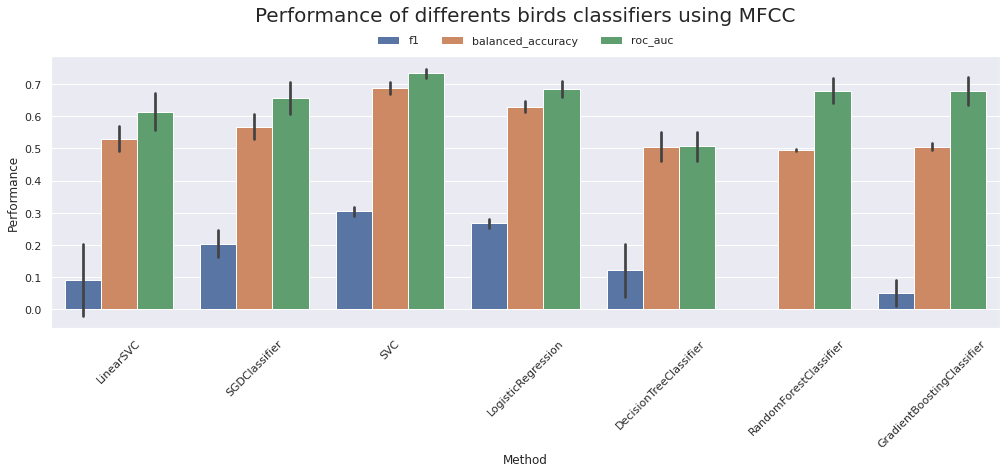

In [ ]:

ax = sns.barplot(data=df_scores,x='Method',y='Performance',hue='Metric Score',ci="sd")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.set_title('Performance of differents birds classifiers using MFCC', fontdict = {'fontsize' : 20}, pad=35)
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Time Performance of differents rain classifiers using MFCC')

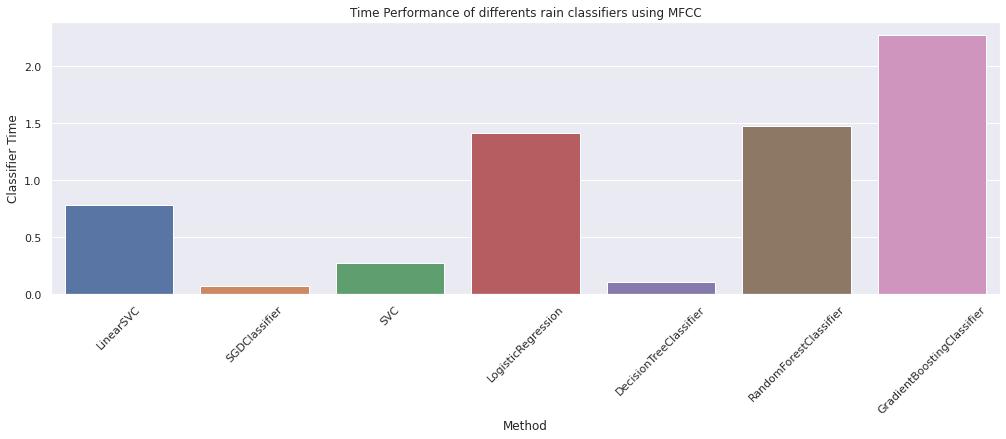

In [ ]:
sns.barplot(data=df_scores,x='Method',y='Classifier Time')
plt.xticks(rotation=45)
plt.title('Time Performance of differents rain classifiers using MFCC')

In [ ]:
df_scores.groupby(['Method','Metric Score'])['Performance'].agg(['mean', 'std'])

mean       std
Method                     Metric Score                         
DecisionTreeClassifier     balanced_accuracy  0.505299  0.050619
                           f1                 0.120886  0.091869
                           roc_auc            0.505921  0.051267
GradientBoostingClassifier balanced_accuracy  0.505363  0.011987
                           f1                 0.049566  0.045545
                           roc_auc            0.679797  0.048599
LinearSVC                  balanced_accuracy  0.529936  0.043527
                           f1                 0.090601  0.124401
                           roc_auc            0.614283  0.064987
LogisticRegression         balanced_accuracy  0.630099  0.020357
                           f1                 0.266976  0.015753
                           roc_auc            0.684375  0.028302
RandomForestClassifier     balanced_accuracy  0.494280  0.002667
                           f1                 0.000000  0.000000
                           roc_auc            0.679657  0.044343
SGDClassifier              balanced_accuracy  0.567202  0.042985
                           f1                 0.203365  0.046416
                           roc_auc            0.657421  0.056521
SVC                        balanced_accuracy  0.688049  0.021495
                           f1                 0.304507  0.015517
                           roc_auc            0.733953  0.015730

In [ ]:
#%% Tune model hyperparameters
clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample')


# Set tuning strategy
param_grid = {'n_estimators' : [1, 5, 10, 100, 300, 500],
              'max_features' : [2, 6, 10, 14, 18]}

skf = StratifiedKFold(n_splits=10)
clf_gs = GridSearchCV(clf, param_grid, scoring=['f1'], 
                           refit='f1', cv=skf, return_train_score=True,
                           n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
#%% Evaluation: compute metrics, error analysis
print('Mean cross-validated score of the best_estimator:', clf_gs.best_score_)
print('Parameter setting that gave the best results on hold out data', clf_gs.best_params_)

Mean cross-validated score of the best_estimator: 0.229515012828514
Parameter setting that gave the best results on hold out data {'max_features': 18, 'n_estimators': 1}


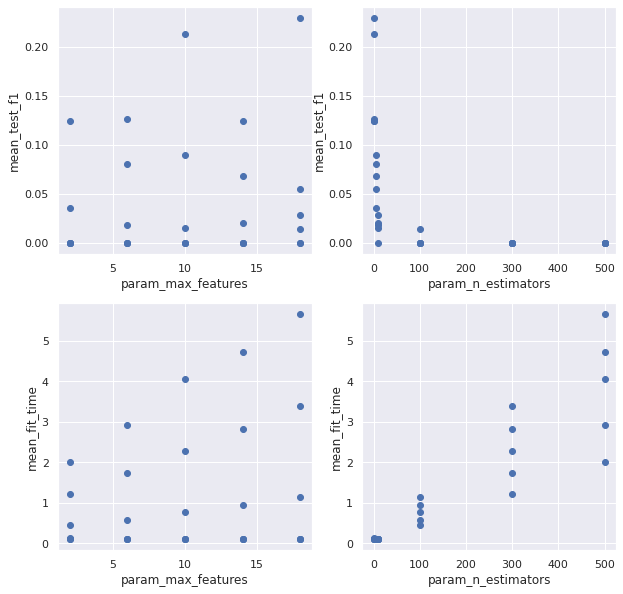

In [ ]:
# Plots to explore results of cross-validation
params = ['param_max_features', 'param_n_estimators']
metrics = ['mean_test_f1', 'mean_fit_time']
fig, ax = plt.subplots(2,2, figsize=[10,10])

ax[0,0].plot(clf_gs.cv_results_[params[0]].tolist(), clf_gs.cv_results_[metrics[0]], 'o')
ax[0,0].set_xlabel(params[0]); ax[0,0].set_ylabel(metrics[0]);

ax[0,1].plot(clf_gs.cv_results_[params[1]].tolist(), clf_gs.cv_results_[metrics[0]], 'o')
ax[0,1].set_xlabel(params[1]); ax[0,1].set_ylabel(metrics[0]);

ax[1,0].plot(clf_gs.cv_results_[params[0]].tolist(), clf_gs.cv_results_[metrics[1]], 'o')
ax[1,0].set_xlabel(params[0]); ax[1,0].set_ylabel(metrics[1]);

ax[1,1].plot(clf_gs.cv_results_[params[1]].tolist(), clf_gs.cv_results_[metrics[1]], 'o')
ax[1,1].set_xlabel(params[1]); ax[1,1].set_ylabel(metrics[1]);



In [ ]:
#%% Final evaluation on test data
y_pred = clf_gs.predict(X_test)
score = f1_score(y_test, y_pred)

In [ ]:
score

0.1509433962264151